# ValueInvestor




## Background:


We are a portfolio investment company and we make investments in the emerging markets around the world. Our company profits by investing in profitable companies, buying, holding and selling company stocks based on value investing principles.


Our goal is to establish a robust intelligent system to aid our value investing efforts using stock market data. We make investment decisions and based on intrinsic value of companies and do not trade on the basis of daily market volatility. Our profit realization strategy typically involves weekly, monthly and quarterly performance of stocks we buy or hold.


## Data Description:


You are given a set of portfolio companies trading data from emerging markets including 2020 Q1-Q2-Q3-Q4 2021 Q1 stock prices. Each company stock is provided in different sheets. Each market's operating days varies based on the country of the company and the market the stocks are exchanged. Use only 2020 data and predict with 2021 Q1 data.


## Goal(s):


Predict stock price valuations on a daily, weekly and monthly basis. Recommend BUY, HOLD, SELL decisions. Maximize capital returns, minimize losses. Ideally a loss should never happen. Minimize HOLD period.


## Success Metrics:


Evaluate on the basis of capital returns. Use Bollinger Bands to measure your systems effectiveness.


In [5]:
# Import libraries 
%matplotlib inline

import math
import glob, os
import pandas as pd 
import numpy as np
from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook


from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.gofplots import qqplot
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot

import itertools
from functools import reduce


from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.api as sm #i like statsmodels result table, lets me explore the coefficents more.
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier


from sklearn.feature_selection import SelectFromModel
from yellowbrick.model_selection import RFECV

from sklearn.model_selection import KFold

from statsmodels.tsa.stattools import adfuller

# import warnings filter
from warnings import simplefilter

from fbprophet import Prophet
np.warnings.filterwarnings('ignore')

C:\Users\abebu\DS\envs\ZA\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


In [ ]:
files = glob.glob('Data/*.csv')
print(files)

In [ ]:
files = glob.glob('Data/*.csv')
emerging_stocks = pd.concat([pd.read_csv(stocks).assign(filename=os.path.basename(stocks).split('.')[0]) for stocks in files]).reset_index()
emerging_stocks

# Stock Price Prediction - Last Value Method 

Pridict the daily prices of Turkey - Koc Holding AS (KCHOL), using data from the previous N days. 
Forecast Horizon = 1

In [ ]:


#### Input params ##################
stk_path = "./data/Turkey - Koc Holding AS (KCHOL).csv"
test_size = 0.2                 # proportion of dataset to be used as test set
cv_size = 0.2                   # proportion of dataset to be used as cross-validation set
Nmax = 2                       # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                                # Nmax is the maximum N we are going to test
fontsize = 14
ticklabelsize = 14
####################################

## Common functions

In [ ]:

def get_preds_mov_avg(df, target_col, N, pred_min, offset):
    """
    Given a dataframe, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Using simple moving average.
    Inputs
        df         : dataframe with the values you want to predict. Can be of any length.
        target_col : name of the column you want to predict e.g. 'price'
        N          : get prediction at timestep t using values from t-1, t-2, ..., t-N
        pred_min   : all predictions should be >= pred_min
        offset     : for df we only do predictions for df[offset:]. e.g. offset can be size of training set
    Outputs
        pred_list  : list. The predictions for target_col. np.array of length len(df)-offset.
    """
    pred_list = df[target_col].rolling(window = N, min_periods=1).mean() # len(pred_list) = len(df)
    
    # Add one timestep to the predictions
    pred_list = np.concatenate((np.array([np.nan]), np.array(pred_list[:-1])))
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
    
    return pred_list[offset:]

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:

df = pd.read_csv(stk_path)

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'])

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# # Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

In [7]:
# 15 months of historical prices for KCHOL stock
df['date'].min(), df['date'].max() 

(Timestamp('2020-01-02 00:00:00'), Timestamp('2021-03-31 00:00:00'))

Text(0, 0.5, 'USD')

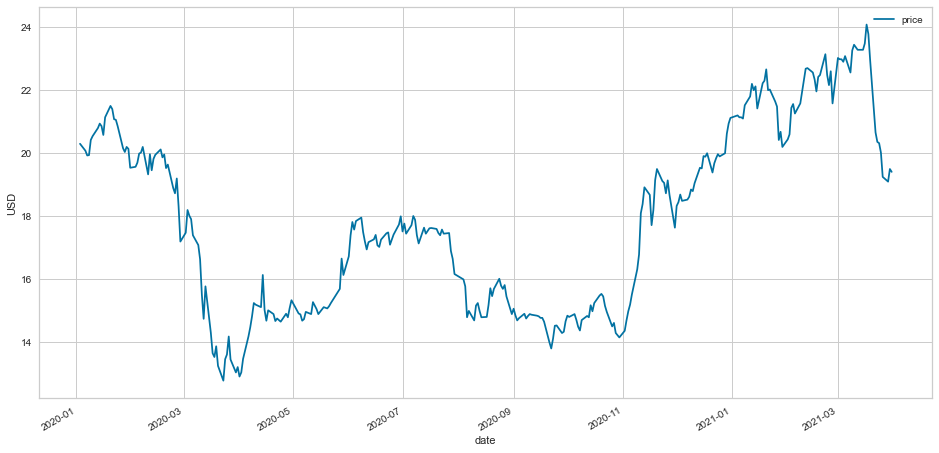

In [90]:
# Plot price over time
rcParams['figure.figsize'] = 16, 8 # width 10, height 8

ax = df.plot(x='date', y='price', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

## Split into train, valdation and test set
`Split dataset into 60% train, 20% validation, and 20% test. The model will be trained using the train set, model hyperparameters will be tuned using the validation set, and finally the performance of the model will be reported using the test set.`

In [10]:

# Get sizes of each of the datasets
num_cv = int(cv_size*len(df)) # proportion of dataset to be used as cross-validation set
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train].copy()
cv = df[num_train:num_train+num_cv].copy()
train_cv = df[:num_train+num_cv].copy()
test = df[num_train+num_cv:].copy()
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 189
num_cv = 63
num_test = 63
train.shape = (189, 8)
cv.shape = (63, 8)
train_cv.shape = (252, 8)
test.shape = (63, 8)


In [11]:
test['date'].min(), test['date'].max()

(Timestamp('2021-01-04 00:00:00'), Timestamp('2021-03-31 00:00:00'))

Text(0, 0.5, 'USD')

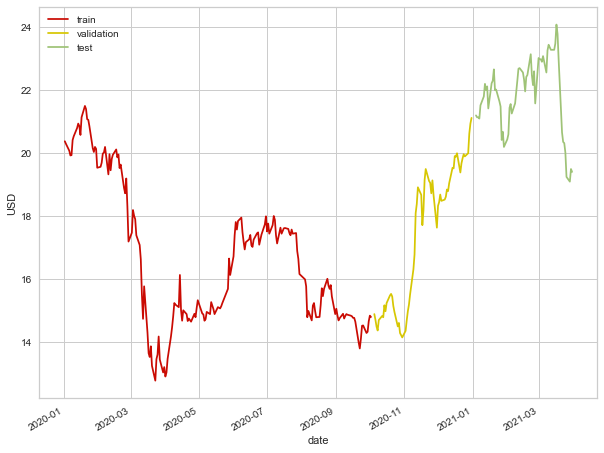

In [12]:

# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
plt.rcParams.update({'font.size': 14})

ax = train.plot(x='date', y='price', style='r-', grid=True)
ax = cv.plot(x='date', y='price', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='price', style='g-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

## Predict using Moving Average

`To evaluate the effectiveness of our methods, we will use the root mean square error (RMSE) and mean absolute percentage error (MAPE) metrics. For both metrics, the lower the value, the better the prediction.`

In [13]:
RMSE = [] # Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors).
mape = [] # mean absolute percentage error (MAPE) 
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list = get_preds_mov_avg(train_cv, 'price', N, 0, num_train)
    
    cv.loc[:, 'est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['price'])))
    mape.append(get_mape(cv['price'], est_list))
print('RMSE = ' + str(RMSE))
print('MAPE = ' + str(mape))
df.head()

RMSE = [0.4072575722546239, 0.49211682378675936]
MAPE = [1.788962875528409, 2.08623042796275]


,date,price,open,high,low,vol.,change_%,month
314,2020-01-02,20.38,20.42,20.44,20.24,2.53M,0.30%,1
313,2020-01-03,20.30,20.30,20.44,19.97,3.31M,-0.39%,1
312,2020-01-06,20.08,20.34,20.34,19.97,1.94M,-1.08%,1
311,2020-01-07,19.93,20.22,20.28,19.92,2.89M,-0.75%,1
310,2020-01-08,19.94,19.89,19.95,19.66,2.79M,0.05%,1


Text(0, 0.5, 'RMSE')

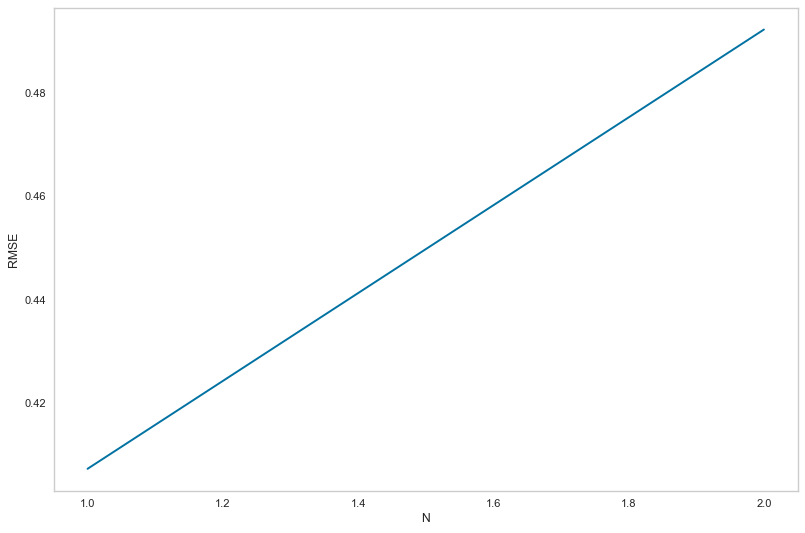

In [14]:
# Plot RMSE versus N
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')

Text(0, 0.5, 'MAPE')

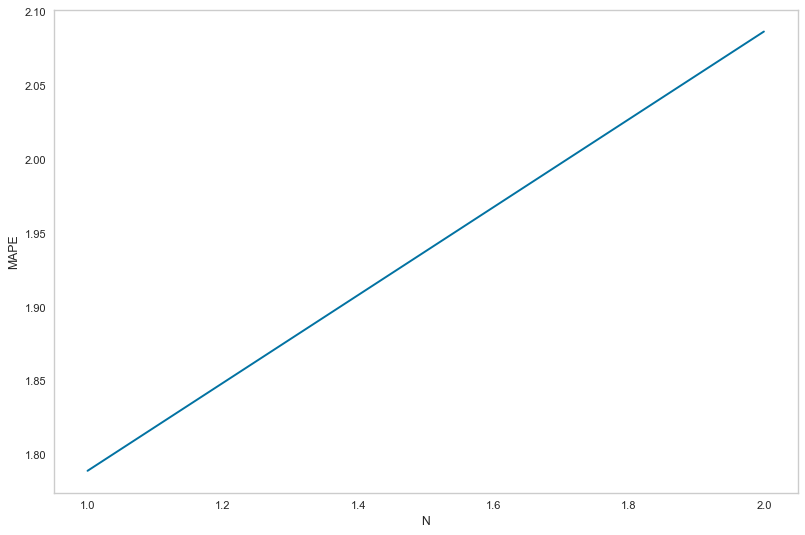

In [15]:
# Plot MAPE versus N. Note for MAPE smaller better. 
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), mape, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('MAPE')

In [16]:
# Set optimum N
N_opt = 1

## Plot Predictions on Validation set

Text(0, 0.5, 'USD')

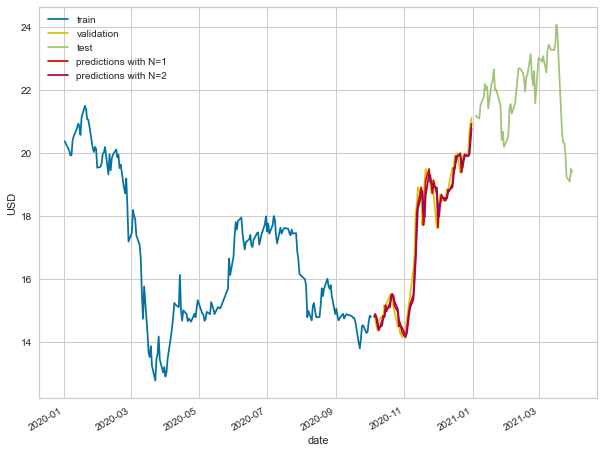

In [18]:
# Plot price over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
plt.rcParams.update({'font.size': 14})

ax = train.plot(x='date', y='price', style='b-', grid=True)
ax = cv.plot(x='date', y='price', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='price', style='g-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='r-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N2', style='m-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N=1', 'predictions with N=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to validation set')

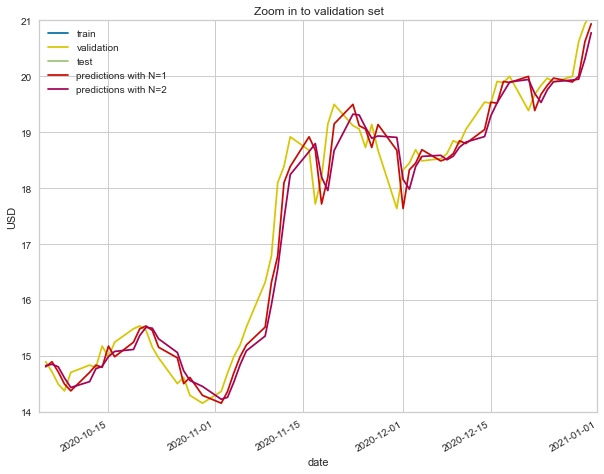

In [19]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='price', style='bx-', grid=True)
ax = cv.plot(x='date', y='price', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='price', style='gx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='rx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N2', style='mx-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N=1', 'predictions with N=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2020, 10, 4), date(2021, 1, 1)])
ax.set_ylim([14, 21])
ax.set_title('Zoom in to validation set')

## Final Model - Last Value

In [20]:
est_list = get_preds_mov_avg(df, 'price', N_opt, 0, num_train+num_cv)
test.loc[:, 'est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['price'])))
print("MAPE = %0.3f%%" % get_mape(test['price'], est_list))
test.head()

RMSE = 0.536
MAPE = 1.723%


,date,price,open,high,low,vol.,change_%,month,est_N1
62,2021-01-04,21.20,21.12,21.50,21.04,10.53M,0.38%,1,21.12
61,2021-01-05,21.14,21.00,21.60,20.86,15.65M,-0.28%,1,21.20
60,2021-01-06,21.14,21.24,21.34,20.86,12.23M,0.00%,1,21.14
59,2021-01-07,21.10,21.20,21.26,20.88,7.91M,-0.19%,1,21.14
58,2021-01-08,21.52,21.22,21.52,21.12,10.36M,1.99%,1,21.10


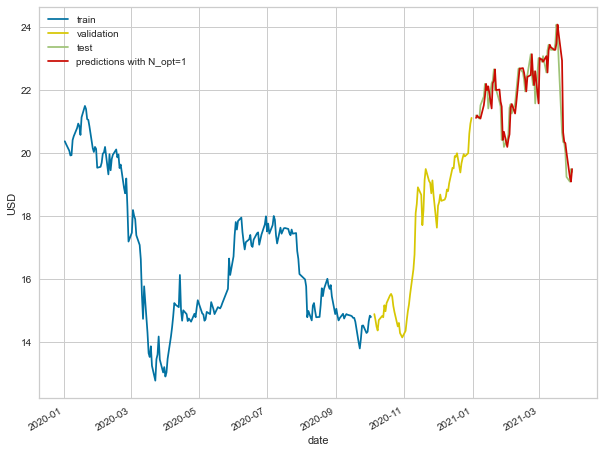

In [22]:
# Plot price over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='price', style='b-', grid=True)
ax = cv.plot(x='date', y='price', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='price', style='g-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N1', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N_opt=1'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
plt.rcParams.update({'font.size': 14})

Text(0.5, 1.0, 'Zoom in to test set')

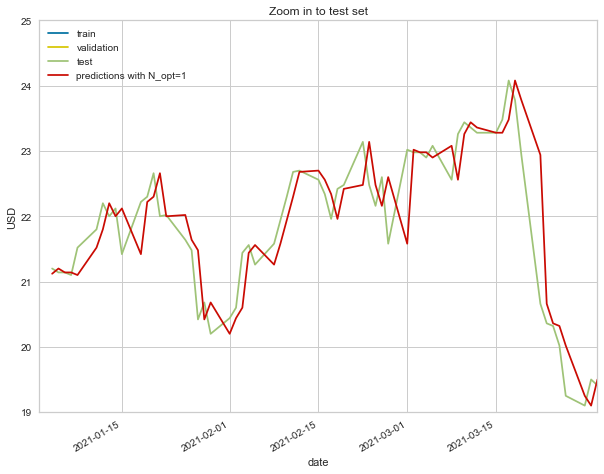

In [23]:
# Plot price over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='price', style='bx-', grid=True)
ax = cv.plot(x='date', y='price', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='price', style='gx-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N1', style='rx-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N_opt=1'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2021, 1, 2), date(2021, 3, 31)])
ax.set_ylim([19, 25])
ax.set_title('Zoom in to test set')

In the Last Value method, we simply set the prediction as the last observed value. In our context, this means we set the current price as the previous day’s price. This is the most cost-effective forecasting model and is commonly used as a benchmark against which more sophisticated models can be compared. There are no hyperparameters to be tuned here.

In [24]:
# Save as csv
test_last_value = test
test_last_value.to_csv("./Output/test_last_value.csv")

# Stock Price Prediction - Moving Average Method

`In the moving average method, the predicted value will be the mean of the previous N values. In our context, this means we set the current price as the mean of the price of the previous N days. The hyperparameter N needs to be tuned.`

- center_ma(t) = mean(obs(t-1), obs(t), obs(t+1))
- trail_ma(t) = mean(obs(t-2), obs(t-1), obs(t))

In [25]:
#### Input params ##################
test_size = 0.2                 # proportion of dataset to be used as test set
cv_size = 0.2                   # proportion of dataset to be used as cross-validation set
Nmax = 21                       # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                                # Nmax is the maximum N we are going to test
fontsize = 14
ticklabelsize = 14
####################################

In [26]:
RMSE = []
mape = []
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list = get_preds_mov_avg(train_cv, 'price', N, 0, num_train)
    
    cv.loc[:, 'est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['price'])))
    mape.append(get_mape(cv['price'], est_list))
print('RMSE = ' + str(RMSE))
print('MAPE = ' + str(mape))
df.head()

RMSE = [0.4072575722546239, 0.49211682378675936, 0.5710045605009426, 0.6402798092451336, 0.706354108775568, 0.7737668689912363, 0.8377788325125108, 0.8972013087886487, 0.9522195468754543, 1.0068862895084034, 1.0568874575814196, 1.1027609700450385, 1.1447048391528438, 1.1829260854950898, 1.2177766423352372, 1.2500962661344026, 1.2814015757569062, 1.3117355700602604, 1.3411770472746996, 1.3697173674399648, 1.3979452066692173]
MAPE = [1.788962875528409, 2.08623042796275, 2.461876333406043, 2.757746271290718, 2.9910018493817674, 3.175207827920381, 3.382217283971467, 3.5913270491868134, 3.810119684956443, 4.031875966308345, 4.209656465733926, 4.385148868783742, 4.539262531931588, 4.680723731564243, 4.817344631341899, 4.938040574363132, 5.077637292798267, 5.21961130714081, 5.361418429657175, 5.528740502724672, 5.705823611125193]


,date,price,open,high,low,vol.,change_%,month
314,2020-01-02,20.38,20.42,20.44,20.24,2.53M,0.30%,1
313,2020-01-03,20.30,20.30,20.44,19.97,3.31M,-0.39%,1
312,2020-01-06,20.08,20.34,20.34,19.97,1.94M,-1.08%,1
311,2020-01-07,19.93,20.22,20.28,19.92,2.89M,-0.75%,1
310,2020-01-08,19.94,19.89,19.95,19.66,2.79M,0.05%,1


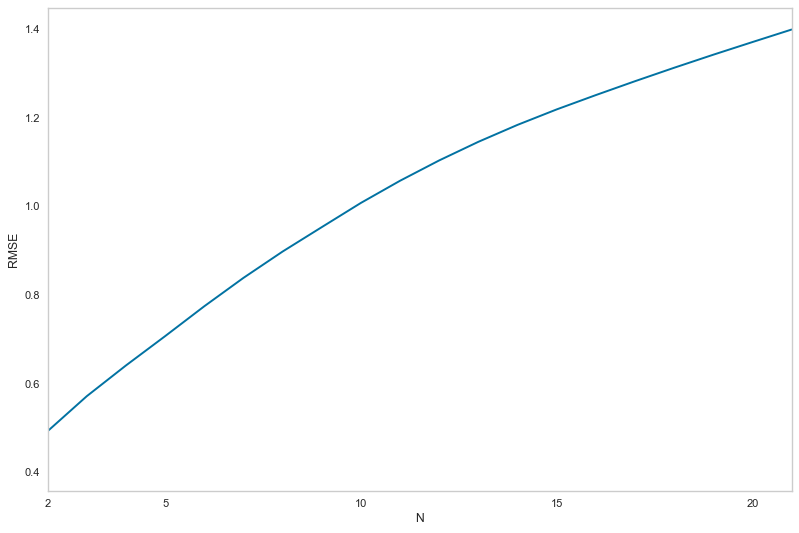

In [28]:
# Plot RMSE versus N
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')
plt.xlim([2,21])
plt.xticks([2, 5, 10, 15, 20])
plt.rcParams.update({'font.size': 14})

([<matplotlib.axis.XTick at 0x17f6990cc48>,
 <a list of 5 Text major ticklabel objects>)

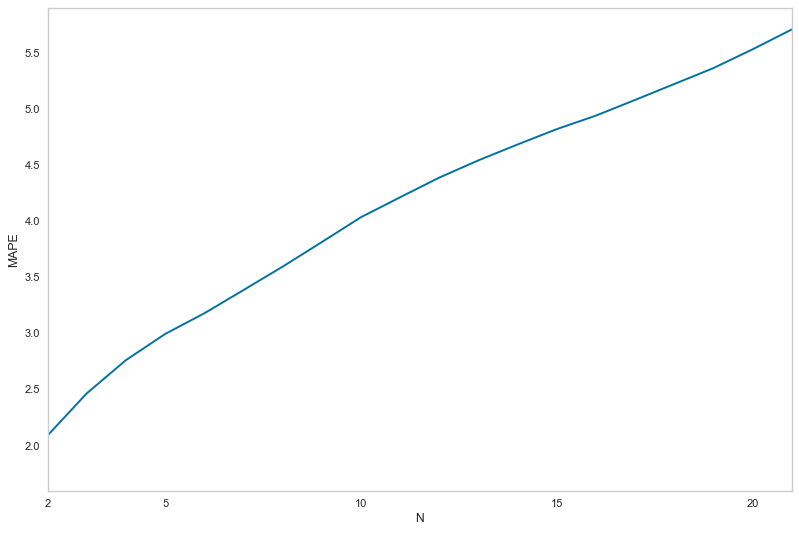

In [29]:
# Plot MAPE versus N. Note for MAPE smaller better. 
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), mape, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('MAPE')
plt.xlim([2, 21])
plt.xticks([2, 5, 10, 15, 20])

In [30]:
# Set optimum N
N_opt = 2

## Plot Predictions on validation set

Text(0, 0.5, 'USD')

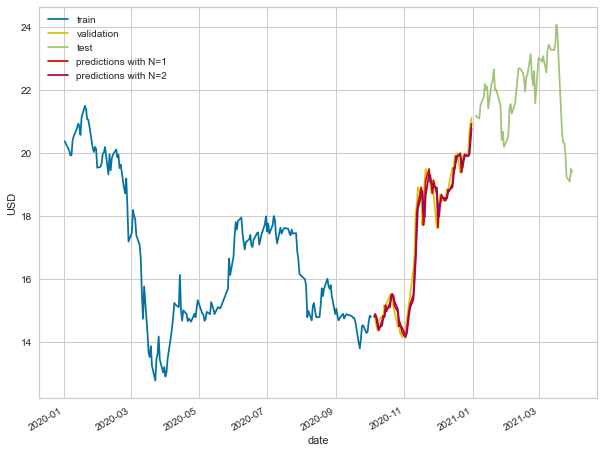

In [31]:
# Plot price over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='price', style='b-', grid=True)
ax = cv.plot(x='date', y='price', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='price', style='g-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='r-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N2', style='m-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N=1', 'predictions with N=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to dev set')

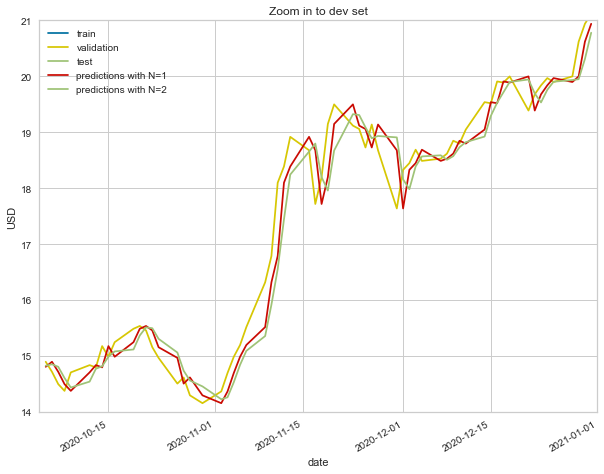

In [32]:
# Plot price over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='price', style='bx-', grid=True)
ax = cv.plot(x='date', y='price', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='price', style='gx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='rx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N2', style='gx-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N=1', 'predictions with N=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2020, 10, 4), date(2021, 1, 1)])
ax.set_ylim([14, 21])
ax.set_title('Zoom in to dev set')

## Final Model - Moving Average

In [33]:
est_list = get_preds_mov_avg(df, 'price', N_opt, 0, num_train+num_cv)
test.loc[:, 'est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['price'])))
print("MAPE = %0.3f%%" % get_mape(test['price'], est_list))
test.head()

RMSE = 0.598
MAPE = 1.983%


,date,price,open,high,low,vol.,change_%,month,est_N1,est_N2
62,2021-01-04,21.20,21.12,21.50,21.04,10.53M,0.38%,1,21.12,21.03
61,2021-01-05,21.14,21.00,21.60,20.86,15.65M,-0.28%,1,21.20,21.16
60,2021-01-06,21.14,21.24,21.34,20.86,12.23M,0.00%,1,21.14,21.17
59,2021-01-07,21.10,21.20,21.26,20.88,7.91M,-0.19%,1,21.14,21.14
58,2021-01-08,21.52,21.22,21.52,21.12,10.36M,1.99%,1,21.10,21.12


Text(0, 0.5, 'USD')

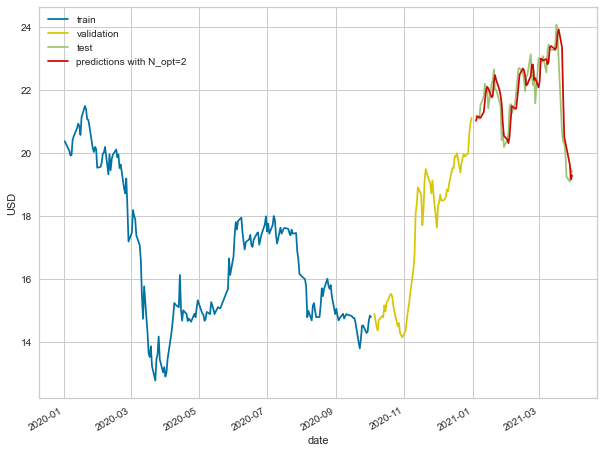

In [34]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='price', style='b-', grid=True)
ax = cv.plot(x='date', y='price', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='price', style='g-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N2', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N_opt=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

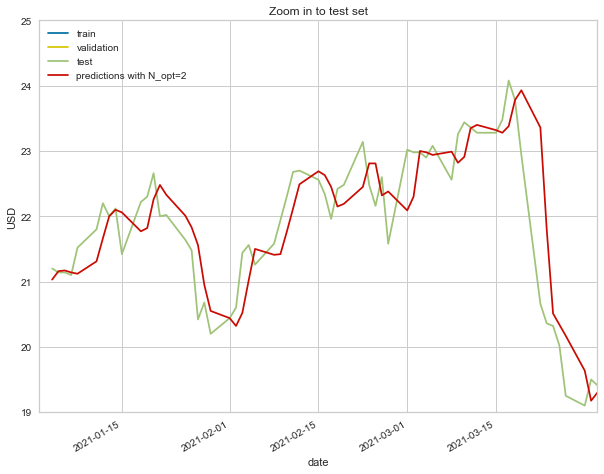

In [35]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='price', style='b-', grid=True)
ax = cv.plot(x='date', y='price', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='price', style='g-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N2', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions with N_opt=2'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

ax.set_xlim([date(2021, 1, 2), date(2021, 3, 31)])
ax.set_ylim([19, 25])
ax.set_title('Zoom in to test set')

(19.0, 25.0)

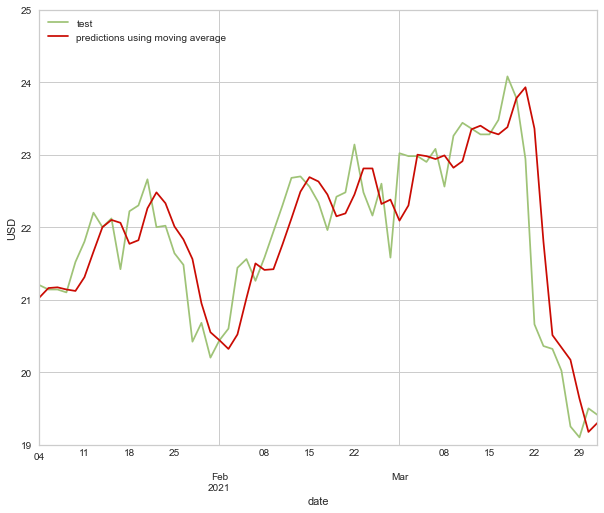

In [37]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
plt.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='price', style='gx-', grid=True)
ax = test.plot(x='date', y='est_N2', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using moving average'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2021, 1, 2), date(2021, 3, 31)])
ax.set_ylim([19, 25])

In [38]:
# Save as csv
test_mov_avg = test
test_mov_avg.to_csv("./Output/test_mov_avg.csv")

## Long Short Term Memory (LSTM)

`Predict stock price in the next day using the Long Short Term Memory (LSTM) method  - given the prices for the last N days, predict for N+1. 
Instead of using the same mean and variance to do scaling for train, validation and test sets, we scale the train set to have mean 0 and var 1, and then whenever we do prediction on valid or test set we scale the previous N values to also have mean 0 and var 1 (ie. use the means and variances of the previous N values to do scaling. We do this for both feature columns and target columns).`



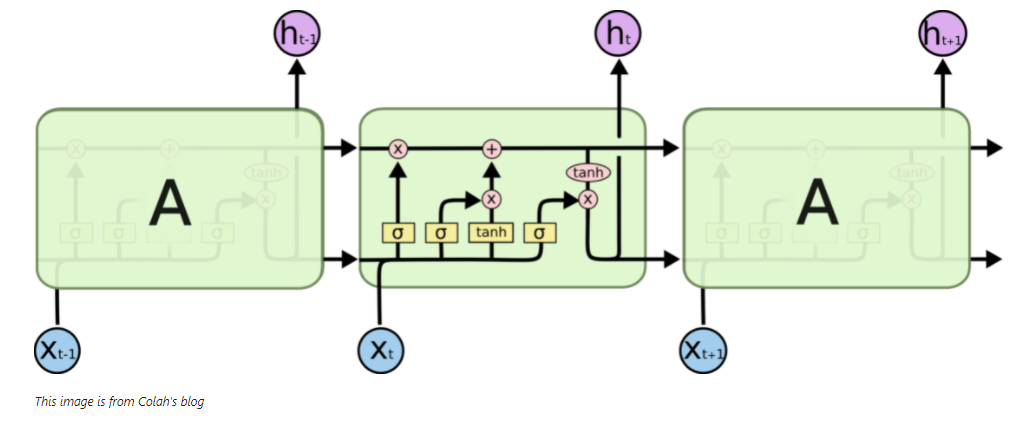

http://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [39]:
%matplotlib inline

import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date
from matplotlib import pyplot as plt
from numpy.random import seed
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils.vis_utils import plot_model

#### Input params ##################
stk_path = "./data/VTI.csv"
test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set

N = 9                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features. 
                               # initial value before tuning
lstm_units=50                  # lstm param. initial value before tuning.
dropout_prob=0.7               # lstm param. initial value before tuning.
optimizer='adam'               # lstm param. initial value before tuning.
epochs=1                       # lstm param. initial value before tuning.
batch_size=1                   # lstm param. initial value before tuning.

model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

# Set seeds to ensure same output results
seed(101)
tf.random.set_seed(model_seed)

### Helper Functions

In [40]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_x_y(data, N, offset):
    """
    Split data into x (features) and y (target)
    """
    x, y = [], []
    for i in range(offset, len(data)):
        x.append(data[i-N:i])
        y.append(data[i])
    x = np.array(x)
    y = np.array(y)
    
    return x, y

def get_x_scaled_y(data, N, offset):
    """
    Split data into x (features) and y (target)
    We scale x to have mean 0 and std dev 1, and return this.
    We do not scale y here.
    Inputs
        data     : pandas series to extract x and y
        N
        offset
    Outputs
        x_scaled : features used to predict y. Scaled such that each element has mean 0 and std dev 1
        y        : target values. Not scaled
        mu_list  : list of the means. Same length as x_scaled and y
        std_list : list of the std devs. Same length as x_scaled and y
    """
    x_scaled, y, mu_list, std_list = [], [], [], []
    for i in range(offset, len(data)):
        mu_list.append(np.mean(data[i-N:i]))
        std_list.append(np.std(data[i-N:i]))
        x_scaled.append((data[i-N:i]-mu_list[i-offset])/std_list[i-offset])
        y.append(data[i])
    x_scaled = np.array(x_scaled)
    y = np.array(y)
    
    return x_scaled, y, mu_list, std_list

def train_pred_eval_model(x_train_scaled, \
                          y_train_scaled, \
                          x_cv_scaled, \
                          y_cv, \
                          mu_cv_list, \
                          std_cv_list, \
                          lstm_units=50, \
                          dropout_prob=0.5, \
                          optimizer='adam', \
                          epochs=1, \
                          batch_size=1):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use LSTM here.
    Returns rmse, mape and predicted values
    Inputs
        x_train_scaled  : e.g. x_train_scaled.shape=(451, 9, 1). Here we are using the past 9 values to predict the next value
        y_train_scaled  : e.g. y_train_scaled.shape=(451, 1)
        x_cv_scaled     : use this to do predictions 
        y_cv            : actual value of the predictions
        mu_cv_list      : list of the means. Same length as x_scaled and y
        std_cv_list     : list of the std devs. Same length as x_scaled and y 
        lstm_units      : lstm param
        dropout_prob    : lstm param
        optimizer       : lstm param
        epochs          : lstm param
        batch_size      : lstm param
    Outputs
        rmse            : root mean square error
        mape            : mean absolute percentage error
        est             : predictions
    '''
    # Create the LSTM network
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
    model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
    model.add(Dense(1))

    # Compile and fit the LSTM network
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)
    
    # Do prediction
    est_scaled = model.predict(x_cv_scaled)
    est = (est_scaled * np.array(std_cv_list).reshape(-1,1)) + np.array(mu_cv_list).reshape(-1,1)
    
    # Calculate RMSE and MAPE
#     print("x_cv_scaled = " + str(x_cv_scaled))
#     print("est_scaled = " + str(est_scaled))
#     print("est = " + str(est))
    rmse = math.sqrt(mean_squared_error(y_cv, est))
    mape = get_mape(y_cv, est)
    
    return rmse, mape, est

Text(0, 0.5, 'USD')

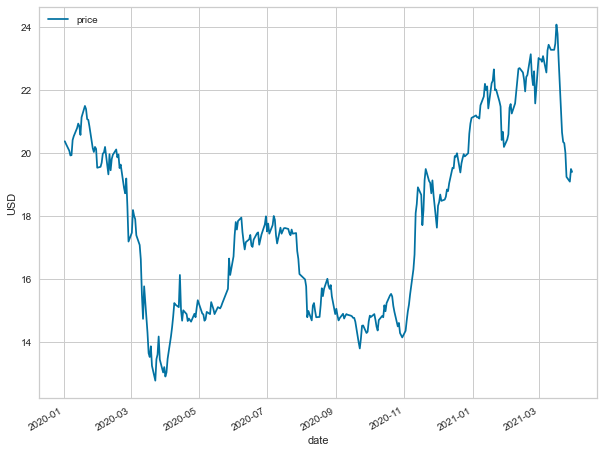

In [41]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='price', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

### Data Processing

In [42]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train][['date', 'price']]
cv = df[num_train:num_train+num_cv][['date', 'price']]
train_cv = df[:num_train+num_cv][['date', 'price']]
test = df[num_train+num_cv:][['date', 'price']]

print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 189
num_cv = 63
num_test = 63
train.shape = (189, 2)
cv.shape = (63, 2)
train_cv.shape = (252, 2)
test.shape = (63, 2)


In [43]:

# Converting dataset into x_train and y_train
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(np.array(train['price']).reshape(-1,1))
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))

# Split into x and y
x_train_scaled, y_train_scaled = get_x_y(train_scaled, N, N)
print("x_train_scaled.shape = " + str(x_train_scaled.shape)) # (446, 7, 1)
print("y_train_scaled.shape = " + str(y_train_scaled.shape)) # (446, 1)

scaler.mean_ = [16.65095238]
scaler.var_ = [4.9588901]
x_train_scaled.shape = (180, 9, 1)
y_train_scaled.shape = (180, 1)


In [44]:
# Scale the cv dataset
# Split into x and y
x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['price']).reshape(-1,1), N, num_train)
print("x_cv_scaled.shape = " + str(x_cv_scaled.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("len(mu_cv_list) = " + str(len(mu_cv_list)))
print("len(std_cv_list) = " + str(len(std_cv_list)))

x_cv_scaled.shape = (63, 9, 1)
y_cv.shape = (63, 1)
len(mu_cv_list) = 63
len(std_cv_list) = 63


In [45]:
# Here we scale the train_cv set, for the final model
scaler_final = StandardScaler()
train_cv_scaled_final = scaler_final.fit_transform(np.array(train_cv['price']).reshape(-1,1))
print("scaler_final.mean_ = " + str(scaler_final.mean_))
print("scaler_final.var_ = " + str(scaler_final.var_))

# # Scale the test dataset
x_test_scaled, y_test, mu_test_list, std_test_list = get_x_scaled_y(np.array(df['price']).reshape(-1,1), N, num_train+num_cv)
print("x_test_scaled.shape = " + str(x_test_scaled.shape))
print("y_test.shape = " + str(y_test.shape))
print("len(mu_test_list) = " + str(len(mu_test_list)))
print("len(std_test_list) = " + str(len(std_test_list)))

scaler_final.mean_ = [16.85142857]
scaler_final.var_ = [5.01783129]
x_test_scaled.shape = (63, 9, 1)
y_test.shape = (63, 1)
len(mu_test_list) = 63
len(std_test_list) = 63


### Create and fit the LSTM network

In [46]:
# Create the LSTM network
model = Sequential()
model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.7
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.7
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=2)

180/180 - 3s - loss: 0.3069 - 3s/epoch - 18ms/step


In [47]:
# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 9, 50)             10400     
                                                                 
 dropout (Dropout)           (None, 9, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


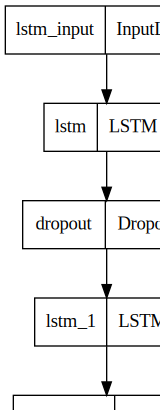

In [48]:
# Plot model and save to file
from IPython.display import SVG
from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot

plot_model(model, to_file='model_lstm_KCHOL.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Train the LSTM Model

In [49]:
# Do prediction
est_scaled = model.predict(x_cv_scaled)
est = (est_scaled * np.array(std_cv_list).reshape(-1,1)) + np.array(mu_cv_list).reshape(-1,1)
print("est.shape = " + str(est.shape))

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, est))
print("RMSE = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_pct_bef_tuning = get_mape(y_cv, est)
print("MAPE = %0.3f%%" % mape_pct_bef_tuning)

est.shape = (63, 1)
RMSE = 1.062
MAPE = 4.236%


### Plotting predictions from the LSMS Network 

Text(0, 0.5, 'USD')

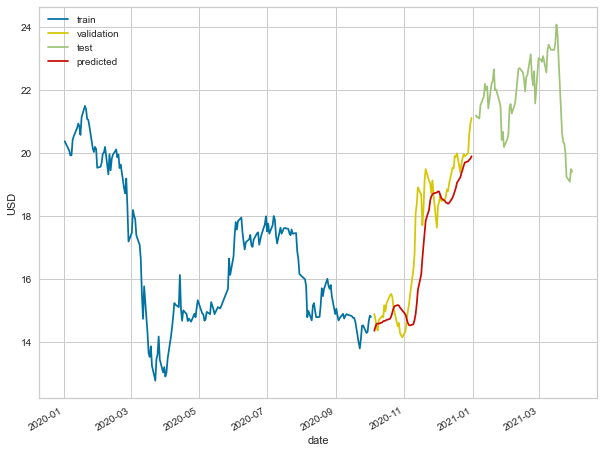

In [50]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'y_cv': y_cv.reshape(-1),
                       'date': cv['date']})

ax = train.plot(x='date', y='price', style='b-', grid=True)
ax = cv.plot(x='date', y='price', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='price', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predicted'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to validation set')

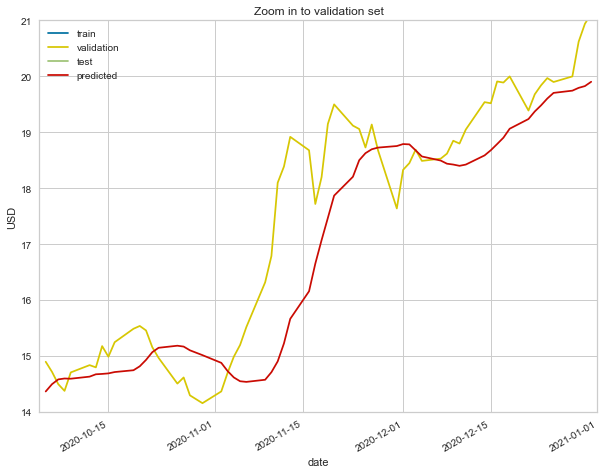

In [51]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'y_cv': y_cv.reshape(-1),
                       'date': cv['date']})

ax = train.plot(x='date', y='price', style='b-', grid=True)
ax = cv.plot(x='date', y='price', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='price', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predicted'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2020, 10, 4), date(2021, 1, 1)])
ax.set_ylim([14, 21])
ax.set_title('Zoom in to validation set')

## Tuning N (no. of days to use as features)

In [52]:

param_label = 'N'
param_list = range(3, 60)

error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    # Split train into x and y
    x_train_scaled, y_train_scaled = get_x_y(train_scaled, param, param)

    # Split cv into x and y
    x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['price']).reshape(-1,1), param, num_train)
    
    # Train, predict and eval model
    rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                          y_train_scaled, \
                                          x_cv_scaled, \
                                          y_cv, \
                                          mu_cv_list, \
                                          std_cv_list, \
                                          lstm_units=lstm_units, \
                                          dropout_prob=dropout_prob, \
                                          optimizer=optimizer, \
                                          epochs=epochs, \
                                          batch_size=batch_size)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

  0%|          | 0/57 [00:00<?, ?it/s]

Minutes taken = 5.575225381056468


,N,rmse,mape_pct
0,3,0.66,2.87
1,4,0.76,3.30
2,5,0.82,3.43
3,6,0.87,3.56
4,7,0.95,3.82
5,8,1.02,4.08
6,9,1.10,4.38
7,10,1.06,4.22
8,11,1.10,4.39
9,12,1.10,4.39


Text(0, 0.5, 'RMSE/MAPE(%)')

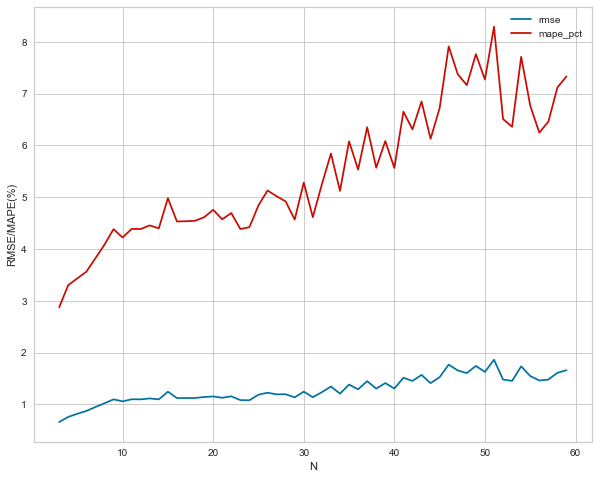

In [53]:

# Plot RMSE 
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = error_rate.plot(x='N', y='rmse', style='bx-', grid=True)
ax = error_rate.plot(x='N', y='mape_pct', style='rx-', grid=True, ax=ax)
ax.set_xlabel("N")
ax.set_ylabel("RMSE/MAPE(%)")

In [54]:

# Get optimum value for param
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
N_opt = temp['N'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(N_opt))

min RMSE = 0.659
min MAPE = 2.874%
optimum N = 3


## Tuning model - epochs and batch_size

In [55]:
param_label = 'epochs'
param_list = [1, 10, 20, 30, 40, 50]

param2_label = 'batch_size'
param2_list = [8, 16, 32, 64, 128]

# Split train into x and y
x_train_scaled, y_train_scaled = get_x_y(train_scaled, N_opt, N_opt)

# Split cv into x and y
x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_x_scaled_y(np.array(train_cv['price']).reshape(-1,1), N_opt, num_train)

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    for param2 in tqdm_notebook(param2_list):
    
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                              y_train_scaled, \
                                              x_cv_scaled, \
                                              y_cv, \
                                              mu_cv_list, \
                                              std_cv_list, \
                                              lstm_units=lstm_units, \
                                              dropout_prob=dropout_prob, \
                                              optimizer=optimizer, \
                                              epochs=param, \
                                              batch_size=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Minutes taken = 2.8633650302886964


,epochs,batch_size,rmse,mape_pct
0,1,8,0.59,2.53
1,1,16,0.58,2.51
2,1,32,0.57,2.48
3,1,64,0.57,2.48
4,1,128,0.57,2.47
5,10,8,0.66,2.90
6,10,16,0.66,2.89
7,10,32,0.68,2.95
8,10,64,0.61,2.66
9,10,128,0.59,2.55


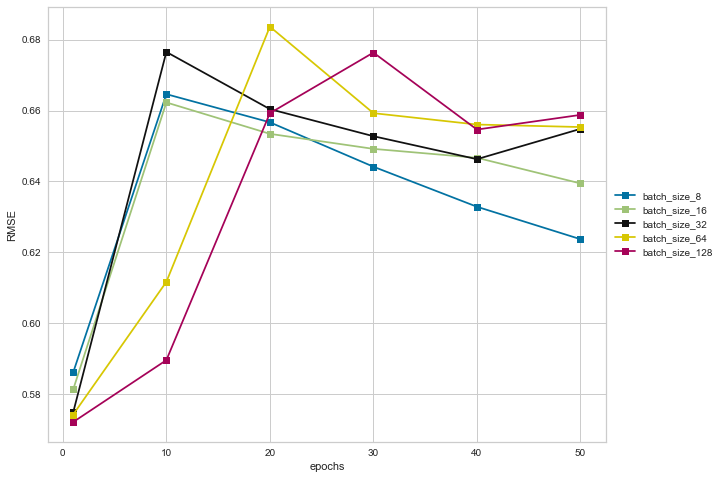

In [56]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure
# ax.set_xlim([10, 50])
# ax.set_ylim([0, 5])

In [57]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
epochs_opt = temp[param_label].values[0]
batch_size_opt = temp[param2_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(epochs_opt))
print("optimum " + param2_label + " = " + str(batch_size_opt))

min RMSE = 0.572
min MAPE = 2.467%
optimum epochs = 1
optimum batch_size = 128


# Tuning model - LSTM units and dropout prob

In [58]:
param_label = 'lstm_units'
param_list = [10, 50, 64, 128]

param2_label = 'dropout_prob'
param2_list = [0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9]

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    for param2 in tqdm_notebook(param2_list):
    
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                              y_train_scaled, \
                                              x_cv_scaled, \
                                              y_cv, \
                                              mu_cv_list, \
                                              std_cv_list, \
                                              lstm_units=param, \
                                              dropout_prob=param2, \
                                              optimizer=optimizer, \
                                              epochs=epochs_opt, \
                                              batch_size=batch_size_opt)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Minutes taken = 2.4034862597783406


,lstm_units,dropout_prob,rmse,mape_pct
0,10,0.10,0.57,2.46
1,10,0.20,0.57,2.47
2,10,0.30,0.57,2.48
3,10,0.50,0.57,2.46
4,10,0.60,0.57,2.47
5,10,0.70,0.57,2.46
6,10,0.80,0.57,2.48
7,10,0.90,0.57,2.47
8,50,0.10,0.57,2.47
9,50,0.20,0.57,2.47


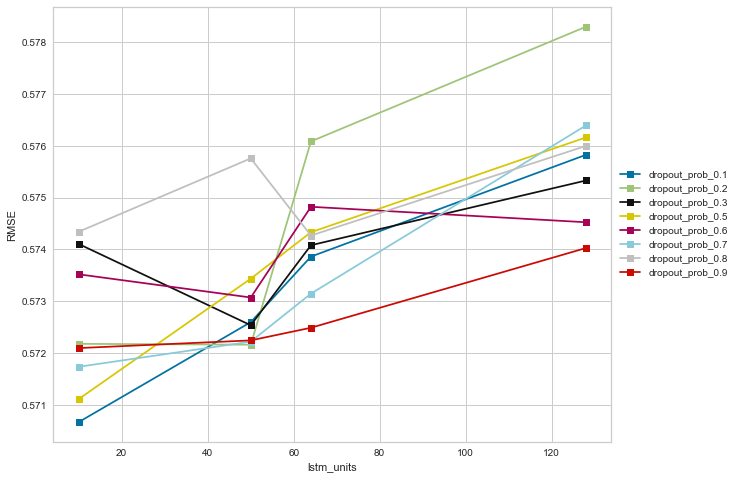

In [59]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [60]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
lstm_units_opt = temp[param_label].values[0]
dropout_prob_opt = temp[param2_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(lstm_units_opt))
print("optimum " + param2_label + " = " + str(dropout_prob_opt))

min RMSE = 0.571
min MAPE = 2.458%
optimum lstm_units = 10
optimum dropout_prob = 0.1


## Tuning model - optimizer

In [61]:
param_label = 'optimizer'
param_list = ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']

error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
   
    # Train, predict and eval model
    rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                          y_train_scaled, \
                                          x_cv_scaled, \
                                          y_cv, \
                                          mu_cv_list, \
                                          std_cv_list, \
                                          lstm_units=lstm_units_opt, \
                                          dropout_prob=dropout_prob_opt, \
                                          optimizer=param, \
                                          epochs=epochs_opt, \
                                          batch_size=batch_size_opt)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

  0%|          | 0/7 [00:00<?, ?it/s]

Minutes taken = 0.4949866016705831


,optimizer,rmse,mape_pct
0,adam,0.57,2.47
1,sgd,0.57,2.45
2,rmsprop,0.57,2.47
3,adagrad,0.57,2.46
4,adadelta,0.57,2.46
5,adamax,0.57,2.47
6,nadam,0.57,2.47


Text(0, 0.5, 'RMSE/MAPE(%)')

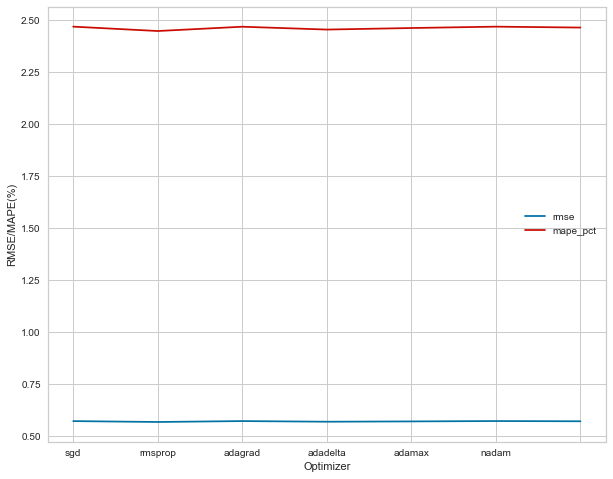

In [62]:
# Plot RMSE 
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = error_rate.plot(x='optimizer', y='rmse', style='bx-', grid=True)
ax = error_rate.plot(x='optimizer', y='mape_pct', style='rx-', grid=True, ax=ax)
ax.set_xticklabels(param_list)
ax.set_xlabel("Optimizer")
ax.set_ylabel("RMSE/MAPE(%)")

In [63]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
optimizer_opt = temp[param_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(optimizer_opt))

min RMSE = 0.568
min MAPE = 2.449%
optimum optimizer = sgd


## Tuned params

In [64]:
d = {'param': ['N', 'lstm_units', 'dropout_prob', 'optimizer', 'epochs', 'batch_size', 'rmse', 'mape_pct'],
     'original': [N, lstm_units, dropout_prob, optimizer, epochs, batch_size, rmse_bef_tuning, mape_pct_bef_tuning],
     'after_tuning': [N_opt, lstm_units_opt, dropout_prob_opt, optimizer_opt, epochs_opt, batch_size_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params

,param,original,after_tuning
0,N,9,3
1,lstm_units,50,10
2,dropout_prob,0.70,0.10
3,optimizer,adam,sgd
4,epochs,1,1
5,batch_size,1,128
6,rmse,1.06,0.57
7,mape_pct,4.24,2.45


## Final Model

In [65]:
# Split train_cv into x and y
x_train_cv_scaled, y_train_cv_scaled = get_x_y(train_cv_scaled_final, N_opt, N_opt)

# Split test into x and y
x_test_scaled, y_test, mu_test_list, std_test_list = get_x_scaled_y(np.array(df['price']).reshape(-1,1), N_opt, num_train+num_cv)

# Train, predict and eval model
rmse, mape, est = train_pred_eval_model(x_train_cv_scaled, \
                                        y_train_cv_scaled, \
                                        x_test_scaled, \
                                        y_test, \
                                        mu_test_list, \
                                        std_test_list, \
                                        lstm_units=lstm_units_opt, \
                                        dropout_prob=dropout_prob_opt, \
                                        optimizer=optimizer_opt, \
                                        epochs=epochs_opt, \
                                        batch_size=batch_size_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

RMSE on test set = 0.690
MAPE on test set = 2.287%


Text(0, 0.5, 'USD')

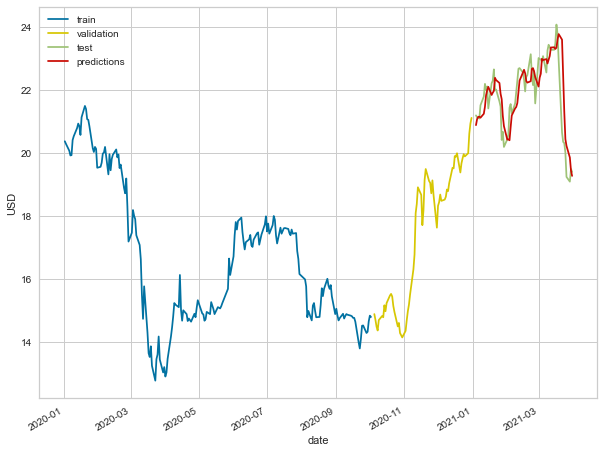

In [66]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'date': df[num_train+num_cv:]['date']})

ax = train.plot(x='date', y='price', style='b-', grid=True)
ax = cv.plot(x='date', y='price', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='price', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

(19.0, 25.0)

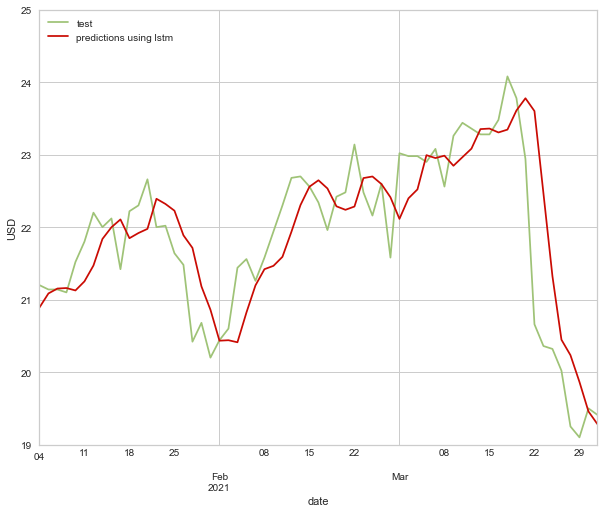

In [67]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='price', style='gx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using lstm'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2021, 1, 2), date(2021, 3, 31)])
ax.set_ylim([19, 25])

In [68]:
# Save as csv
test_lstm = est_df
test_lstm.to_csv("./Output/test_lstm.csv")

## The AutoRegressive Integrated Moving Average (ARIMA) model
- AR: < Auto Regressive > means that the model uses the dependent relationship between an observation and some predefined number of lagged observations (also known as “time lag” or “lag”).
- I:< Integrated > means that the model employs differencing of raw observations (e.g. it subtracts an observation from an observation at the previous time step) in order to make the time-series stationary.MA:
- MA: < Moving Average > means that the model exploits the relationship between the residual error and the observations.

### Model parameters
The standard ARIMA models expect as input parameters 3 arguments i.e. p,d,q.
- p is the number of lag observations.
- d is the degree of differencing.
- q is the size/width of the moving average window.



In [8]:
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


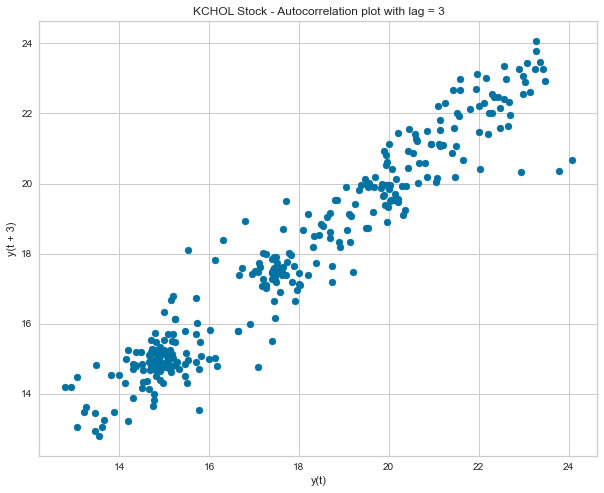

In [9]:
# Before building the ARIMA model, let’s see if there is some cross-correlation in out data.
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
plt.rcParams.update({'font.size': 14})

lag_plot(df['price'], lag=3)
plt.title('KCHOL Stock - Autocorrelation plot with lag = 3')
plt.show()


There is strong auto-correlation in the data. This confirms that ARIMA is a good model to apply. 

## Split into train, valdation and test set
`Split dataset into 60% train, 20% validation, and 20% test. The model will be trained using the train set, model hyperparameters will be tuned using the validation set, and finally the performance of the model will be reported using the test set.`


In [10]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df)) # proportion of dataset to be used as cross-validation set
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train].copy()
cv = df[num_train:num_train+num_cv].copy()
train_cv = df[:num_train+num_cv].copy()
test = df[num_train+num_cv:].copy()
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))


num_train = 189
num_cv = 63
num_test = 63
train.shape = (189, 8)
cv.shape = (63, 8)
train_cv.shape = (252, 8)
test.shape = (63, 8)


Text(0, 0.5, 'USD')

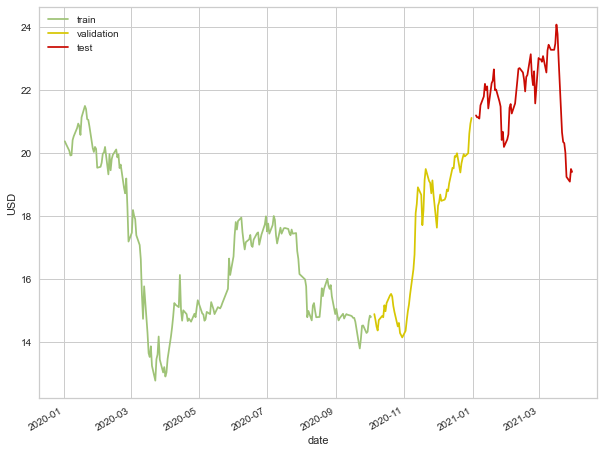

In [11]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
plt.rcParams.update({'font.size': 14})

ax = train.plot(x='date', y='price', style='g-', grid=True)
ax = cv.plot(x='date', y='price', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='price', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [12]:
def test_stationarity(x):


    #Determing rolling statistics
    rolmean = x.rolling(window=22,center=False).mean()

    rolstd = x.rolling(window=22,center=False).std()
    
    #Plot rolling statistics:
    orig = plt.plot(x, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey Fuller test    
    result=adfuller(x)
    print('ADF Stastistic: %f'%result[0])
    print('p-value: %f'%result[1])
    pvalue=result[1]
    for key,value in result[4].items():
         if result[0]>value:
            print("The graph is non stationary")
            break
         else:
            print("The graph is stationary")
            break;
    print('Critical values:')
    for key,value in result[4].items():
        print('\t%s: %.3f ' % (key, value))

In [13]:
df_t = train_cv
df_t.drop(['open', 'high', 'low', 'vol.', 'change_%', 'month'], axis =1, inplace = True)
df_t = df_t.set_index('date')
df_t

,price
date,
2020-01-02,20.38
2020-01-03,20.30
2020-01-06,20.08
2020-01-07,19.93
2020-01-08,19.94
...,...
2020-12-25,19.90
2020-12-28,20.00
2020-12-29,20.62


In [14]:
df_train = train
df_train.drop(['open', 'high', 'low', 'vol.', 'change_%', 'month'], axis =1, inplace = True)
df_train = df_train.set_index('date')
df_train

,price
date,
2020-01-02,20.38
2020-01-03,20.30
2020-01-06,20.08
2020-01-07,19.93
2020-01-08,19.94
...,...
2020-09-28,14.30
2020-09-29,14.34
2020-09-30,14.67


In [15]:
df_cv = cv
df_cv.drop(['open', 'high', 'low', 'vol.', 'change_%', 'month'], axis =1, inplace = True)
df_cv = df_cv.set_index('date')
df_cv

,price
date,
2020-10-05,14.90
2020-10-06,14.72
2020-10-07,14.50
2020-10-08,14.38
2020-10-09,14.71
...,...
2020-12-25,19.90
2020-12-28,20.00
2020-12-29,20.62


In [16]:
df_test = test
df_test.drop(['open', 'high', 'low', 'vol.', 'change_%', 'month'], axis =1, inplace = True)
df_test = df_test.set_index('date')
df_test

,price
date,
2021-01-04,21.20
2021-01-05,21.14
2021-01-06,21.14
2021-01-07,21.10
2021-01-08,21.52
...,...
2021-03-25,20.02
2021-03-26,19.25
2021-03-29,19.10


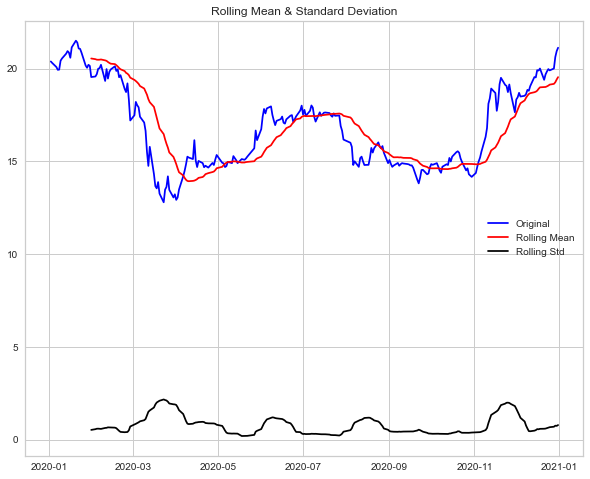

ADF Stastistic: -1.524121
p-value: 0.521547
The graph is non stationary
Critical values:
	1%: -3.457 
	5%: -2.873 
	10%: -2.573 


In [17]:
test_stationarity(df_t)

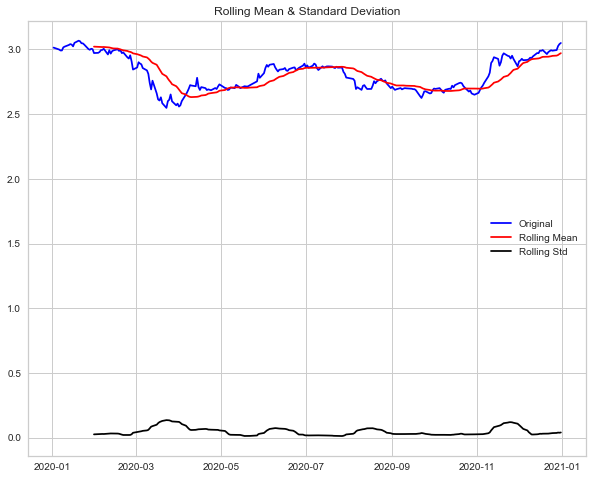

ADF Stastistic: -1.699895
p-value: 0.431166
The graph is non stationary
Critical values:
	1%: -3.457 
	5%: -2.873 
	10%: -2.573 


In [18]:
d_log = np.log(df_t['price'])
df_t['log_price'] = d_log
test_stationarity(df_t['log_price'])

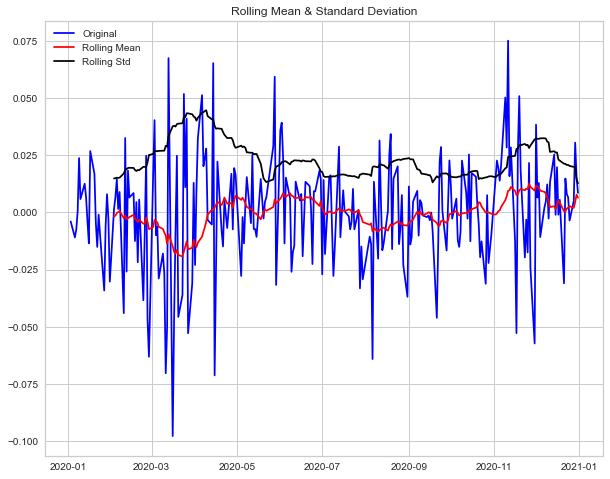

ADF Stastistic: -6.173224
p-value: 0.000000
The graph is stationary
Critical values:
	1%: -3.457 
	5%: -2.873 
	10%: -2.573 


In [19]:
d_log_diff = d_log - d_log.shift()
test_stationarity(d_log_diff.dropna())

In [29]:
df['d_log_price'] = np.log(df['price'])
df['d_log_diff_price'] = df['d_log_price'] - df['d_log_price'].shift()
df

,date,price,open,high,low,vol.,change_%,month,d_log_diff_price,d_log_price
314,2020-01-02,20.38,20.42,20.44,20.24,2.53M,0.30%,1,NaN,3.01
313,2020-01-03,20.30,20.30,20.44,19.97,3.31M,-0.39%,1,-0.00,3.01
312,2020-01-06,20.08,20.34,20.34,19.97,1.94M,-1.08%,1,-0.01,3.00
311,2020-01-07,19.93,20.22,20.28,19.92,2.89M,-0.75%,1,-0.01,2.99
310,2020-01-08,19.94,19.89,19.95,19.66,2.79M,0.05%,1,0.00,2.99
...,...,...,...,...,...,...,...,...,...,...
4,2021-03-25,20.02,20.50,20.86,20.02,15.93M,-1.48%,3,-0.01,3.00
3,2021-03-26,19.25,20.28,20.36,19.10,21.35M,-3.85%,3,-0.04,2.96
2,2021-03-29,19.10,19.24,19.67,19.10,16.56M,-0.78%,3,-0.01,2.95
1,2021-03-30,19.50,19.12,19.81,19.03,21.05M,2.09%,3,0.02,2.97


In [31]:
df = df.dropna()
df


,date,price,open,high,low,vol.,change_%,month,d_log_diff_price,d_log_price
313,2020-01-03,20.30,20.30,20.44,19.97,3.31M,-0.39%,1,-0.00,3.01
312,2020-01-06,20.08,20.34,20.34,19.97,1.94M,-1.08%,1,-0.01,3.00
311,2020-01-07,19.93,20.22,20.28,19.92,2.89M,-0.75%,1,-0.01,2.99
310,2020-01-08,19.94,19.89,19.95,19.66,2.79M,0.05%,1,0.00,2.99
309,2020-01-09,20.42,20.20,20.58,20.08,7.94M,2.41%,1,0.02,3.02
...,...,...,...,...,...,...,...,...,...,...
4,2021-03-25,20.02,20.50,20.86,20.02,15.93M,-1.48%,3,-0.01,3.00
3,2021-03-26,19.25,20.28,20.36,19.10,21.35M,-3.85%,3,-0.04,2.96
2,2021-03-29,19.10,19.24,19.67,19.10,16.56M,-0.78%,3,-0.01,2.95
1,2021-03-30,19.50,19.12,19.81,19.03,21.05M,2.09%,3,0.02,2.97


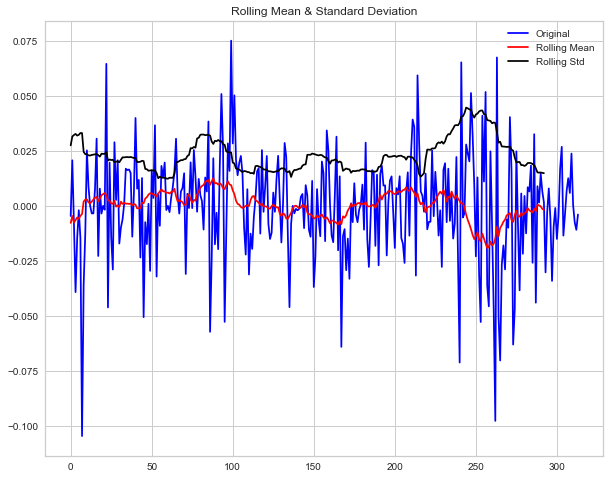

ADF Stastistic: -7.178105
p-value: 0.000000
The graph is stationary
Critical values:
	1%: -3.452 
	5%: -2.871 
	10%: -2.572 


In [30]:
test_stationarity(df['d_log_diff_price'].dropna())

In [32]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df)) # proportion of dataset to be used as cross-validation set
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train].copy()
cv = df[num_train:num_train+num_cv].copy()
train_cv = df[:num_train+num_cv].copy()
test = df[num_train+num_cv:].copy()
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))


num_train = 190
num_cv = 62
num_test = 62
train.shape = (190, 10)
cv.shape = (62, 10)
train_cv.shape = (252, 10)
test.shape = (62, 10)


## Build and Train the ARIMA Model

In [46]:
from statsmodels.tsa.arima_model import ARIMA
# Divide into train and test
train_arima, vald_arima = df_train, df_cv
history = [x for x in train_arima]
predictions = list()
originals = list()
error_list = list()

print('Printing Predicted vs Expected Values...')
print('\n')
# We go over each value in the test set and then apply ARIMA model and calculate the predicted value. 
# We have the expected value in the test set therefore we calculate the error between predicted and expected value 
for t in range(len(vald_arima)):
    model = ARIMA(history, order=(3, 1, 0))
    model_fit = model.fit(disp=-1)
    
    output = model_fit.forecast()
    
    pred_value = output[0]
    
        
    original_value = vald_arima[t]
    history.append(original_value)
    
    pred_value = np.exp(pred_value)
    
    
    original_value = np.exp(original_value)
    
    # Calculating the error
    error = ((abs(pred_value - original_value)) / original_value) * 100
    error_list.append(error)
    print('predicted = %f,   expected = %f,   error = %f ' % (pred_value, original_value, error), '%')
    
    predictions.append(float(pred_value))
    originals.append(float(original_value))
    

### Plotting predictions from the ARIMA Model
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': predictions, 
                       'y_cv': cv_price.reshape(-1),
                       'date': cv['date']})
est_df['est'] = est_df['est'].str[0]
ax = train.plot(x='date', y='price', style='b-', grid=True)
ax = cv.plot(x='date', y='price', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='price', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predicted'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Printing Predicted vs Expected Values...




ValueError: could not convert string to float: 'price'

In [40]:
# As a baseline lets start with the following parameter: arima_parameters
p = 3
d = 1
q = 0

train_price = train['price'].values
cv_price = cv['price'].values
test_price = test['price'].values

history = [x for x in train_price]
model_predictions = []
N_test_observations = len(cv_price)

for time_point in range(N_test_observations):
    model = ARIMA(history, order=(p,d,q))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_cv_value = cv_price[time_point]
    history.append(true_cv_value)

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(cv_price, model_predictions))
print("RMSE = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_pct_bef_tuning = get_mape(cv_price, model_predictions)
print("MAPE = %0.3f%%" % mape_pct_bef_tuning)


RMSE = 0.418
MAPE = 14.287%


Text(0, 0.5, 'USD')

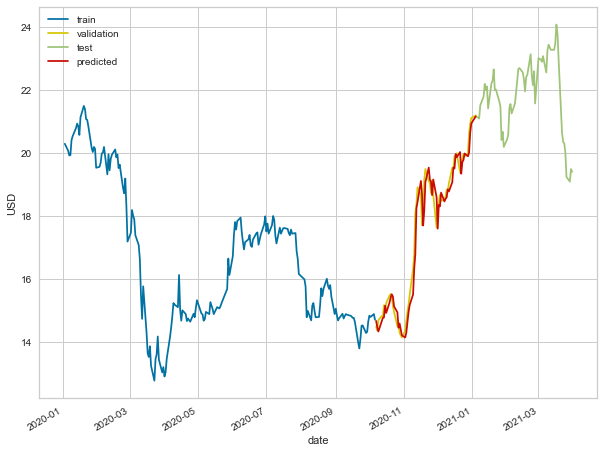

In [41]:

### Plotting predictions from the ARIMA Model
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': model_predictions, 
                       'y_cv': cv_price.reshape(-1),
                       'date': cv['date']})
est_df['est'] = est_df['est'].str[0]
ax = train.plot(x='date', y='price', style='b-', grid=True)
ax = cv.plot(x='date', y='price', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='price', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predicted'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to validation set')

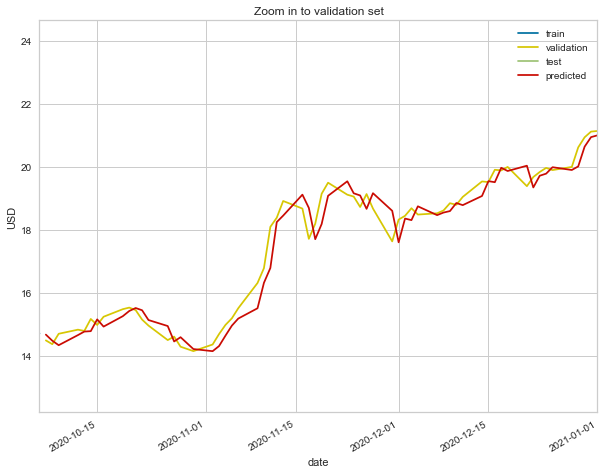

In [45]:


### Zoom in to validation set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': model_predictions, 
                       'y_cv': cv_price.reshape(-1),
                       'date': cv['date']})
est_df['est'] = est_df['est'].str[0]
ax = train.plot(x='date', y='price', style='b-', grid=True)
ax = cv.plot(x='date', y='price', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='price', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predicted'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

ax.set_xlim([date(2020, 10, 6), date(2021, 1, 1)])
#ax.set_ylim([-0.075, 0.075])
ax.set_title('Zoom in to validation set')

## Tuning P,D Q

`The standard ARIMA models expect as input parameters 3 arguments i.e. p,d,q.`
- p is the number of lag observations.
- d is the degree of differencing.
- q is the size/width of the moving average window.

In [49]:

#Parameter Selection for the ARIMA Time Series Model
#our first goal is to find the values of ARIMA(p,d,q)
#We will use a "grid search" to iteratively explore different combinations of parameters. 
#For each combination of parameters, we fit a new  ARIMA model.
p = range(1,21)
d = range(1,4)
q = range(0,4)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
print(len(pdq))

240


In [50]:
cv_price

array([14.5 , 14.38, 14.71, 14.84, 14.8 , 15.18, 14.99, 15.25, 15.49,
       15.54, 15.46, 15.16, 14.97, 14.51, 14.62, 14.3 , 14.16, 14.37,
       14.7 , 14.99, 15.2 , 15.52, 16.32, 16.79, 18.1 , 18.39, 18.92,
       18.68, 17.72, 18.2 , 19.15, 19.5 , 19.12, 19.06, 18.73, 19.14,
       18.68, 17.64, 18.33, 18.45, 18.69, 18.49, 18.53, 18.62, 18.85,
       18.8 , 19.05, 19.54, 19.52, 19.91, 19.89, 20.  , 19.39, 19.68,
       19.84, 19.97, 19.9 , 20.  , 20.62, 20.94, 21.12, 21.2 ])

In [51]:
#When evaluating and comparing statistical models fitted with different parameters, 
#each can be ranked against one another based on how well it fits the data or its ability to accurately predict future data points.
#We will use the AIC (Akaike Information Criterion) value, which is conveniently returned with ARIMA models fitted using statsmodels.
#warnings.filterwarnings("ignore") # specify to ignore warning messages
X = cv_price
aic=[]
param1=[]
warnings.filterwarnings("ignore")
for param in pdq:
    
    try:
        model = ARIMA(X,order=param)
        model_fit = model.fit(disp=0)
        a = model_fit.aic
        param1.append(param)
        aic.append(a)
        print('ARIMA{} - AIC:{}'.format(param,a ))
    except:
        continue
mini = min(aic)
index = aic.index(mini)
print('selscted ARIMA model is ARIMA{} - AIC:{}'.format(param1[index],mini))

ARIMA(1, 1, 0) - AIC:65.18388945160295
ARIMA(1, 1, 1) - AIC:67.16346126033775
ARIMA(1, 1, 2) - AIC:69.1382541739365
ARIMA(1, 1, 3) - AIC:70.99766389481839
ARIMA(1, 2, 0) - AIC:87.41333148727826
ARIMA(1, 2, 1) - AIC:70.92008447146543
ARIMA(1, 2, 2) - AIC:72.52685620779143
ARIMA(1, 2, 3) - AIC:73.74695501239833
ARIMA(2, 1, 0) - AIC:67.15153142958013
ARIMA(2, 1, 1) - AIC:69.13915797903297
ARIMA(2, 1, 2) - AIC:62.67797681842363
ARIMA(2, 1, 3) - AIC:64.65144028822105
ARIMA(2, 2, 0) - AIC:84.61685780846436
ARIMA(2, 2, 1) - AIC:72.91607436517114
ARIMA(2, 2, 2) - AIC:73.66916324028885
ARIMA(2, 2, 3) - AIC:68.46796311339031
ARIMA(3, 1, 0) - AIC:69.06339408006104
ARIMA(3, 1, 1) - AIC:71.04114788894714
ARIMA(3, 1, 2) - AIC:64.45434987337333
ARIMA(3, 1, 3) - AIC:63.82293231146822
ARIMA(3, 2, 0) - AIC:81.3159995547857
ARIMA(3, 2, 1) - AIC:74.88457604348486
ARIMA(3, 2, 2) - AIC:75.6325496382279
ARIMA(3, 2, 3) - AIC:70.33886957501119
ARIMA(4, 1, 0) - AIC:70.87495478467773
ARIMA(4, 1, 1) - AIC:72.7050

# Final Model - ARIMA

In [56]:
# ## Final Model - test dataset
p = 2
d = 1
q = 2

train_price = train['price'].values
cv_price = cv['price'].values
test_price = test['price'].values

history = [x for x in cv_price]
model_predictions = []
N_test_observations = len(test_price)

for time_point in range(N_test_observations):
    model = ARIMA(history, order=(p,d,q))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_price[time_point]
    history.append(true_test_value)

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(test_price, model_predictions))
print("RMSE = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_pct_bef_tuning = get_mape(test_price, model_predictions)
print("MAPE = %0.3f%%" % mape_pct_bef_tuning)


RMSE = 0.559
MAPE = 6.107%


Text(0, 0.5, 'USD')

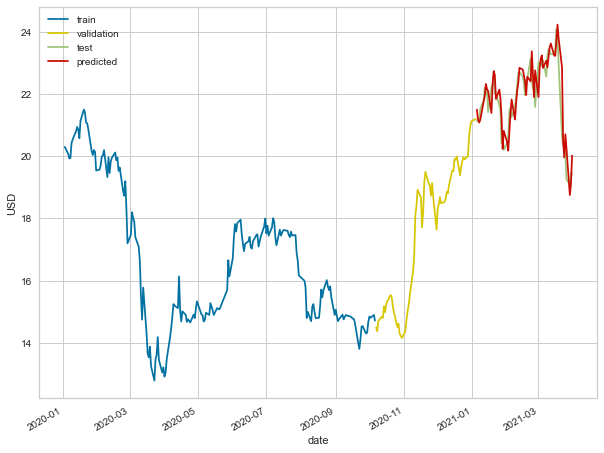

In [57]:
## Final Model - test dataset
### Plotting predictions from the ARIMA Model
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': model_predictions, 
                       'y_cv': test_price.reshape(-1),
                       'date': test['date']})
est_df['est'] = est_df['est'].str[0]
ax = train.plot(x='date', y='price', style='b-', grid=True)
ax = cv.plot(x='date', y='price', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='price', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predicted'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

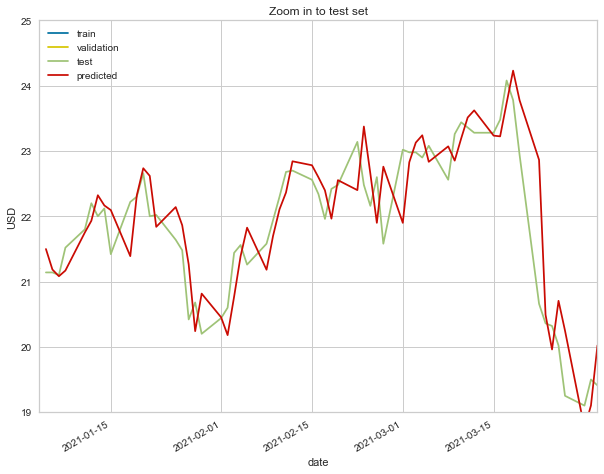

In [61]:
### Zoom in to validation set
## Final Model - test dataset
### Plotting predictions from the ARIMA Model
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': model_predictions, 
                       'y_cv': test_price.reshape(-1),
                       'date': test['date']})
est_df['est'] = est_df['est'].str[0]
ax = train.plot(x='date', y='price', style='b-', grid=True)
ax = cv.plot(x='date', y='price', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='price', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test', 'predicted'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

ax.set_xlim([date(2021, 1,4), date(2021, 3, 31)])
ax.set_ylim([19, 25])
ax.set_title('Zoom in to test set')

In [62]:
# Save as csv
test_ARIMA = est_df
test_ARIMA.to_csv("./Output/test_ARIMA.csv")

In [85]:
test_ARIMA

,est_ARIMA,y_cv,date
61,21.50,21.14,2021-01-05
60,21.18,21.14,2021-01-06
59,21.08,21.10,2021-01-07
58,21.17,21.52,2021-01-08
57,21.75,21.80,2021-01-11
...,...,...,...
4,20.71,20.02,2021-03-25
3,20.25,19.25,2021-03-26
2,18.75,19.10,2021-03-29
1,19.10,19.50,2021-03-30


In [73]:
test_last_value = pd.read_csv('Output/test_last_value.csv', index_col = 0)
test_lstm = pd.read_csv('Output/test_lstm.csv', index_col = 0)
test_mov_avg = pd.read_csv('Output/test_mov_avg.csv', index_col = 0)
test_last_value.shape, test_lstm.shape, test_mov_avg.shape

((63, 9), (63, 2), (63, 10))

In [86]:

test_last_value.rename(columns={'est_N1': 'est_LV'}, inplace=True)
test_last_value = test_last_value[['date', 'est_LV']]
test_lstm.rename(columns={'est_ARIMA': 'est_LSTM'}, inplace=True)
test_lstm = test_lstm[['date', 'est_LSTM']]
test_mov_avg.rename(columns={'est_N2': 'est_MA'}, inplace=True)
test_mov_avg =test_mov_avg[['date', 'est_MA']]
test_ARIMA.rename(columns={'est': 'est_ARIMA'}, inplace=True)
test_ARIMA = test_ARIMA[['date', 'est_ARIMA']]

                             
test_last_value['date'] = pd.to_datetime(test_last_value['date'])
test_lstm['date'] = pd.to_datetime(test_lstm['date'])
test_mov_avg['date'] = pd.to_datetime(test_mov_avg['date'])
test_ARIMA['date'] = pd.to_datetime(test_ARIMA['date'])
data_frames = [test_last_value,test_lstm,test_mov_avg,test_ARIMA]

test_merged = reduce(lambda  left,right: pd.merge(left,right,on=['date'],
                                            how='outer'), data_frames)
test_merged


,date,est_LV,est_LSTM,est_MA,est_ARIMA
0,2021-01-04,21.12,20.89,21.03,NaN
1,2021-01-05,21.20,21.09,21.16,21.50
2,2021-01-06,21.14,21.15,21.17,21.18
3,2021-01-07,21.14,21.16,21.14,21.08
4,2021-01-08,21.10,21.13,21.12,21.17
...,...,...,...,...,...
58,2021-03-25,20.32,20.45,20.34,20.71
59,2021-03-26,20.02,20.23,20.17,20.25
60,2021-03-29,19.25,19.87,19.64,18.75
61,2021-03-30,19.10,19.46,19.18,19.10


# COMPARING MODELS 

Text(0, 0.5, 'USD')

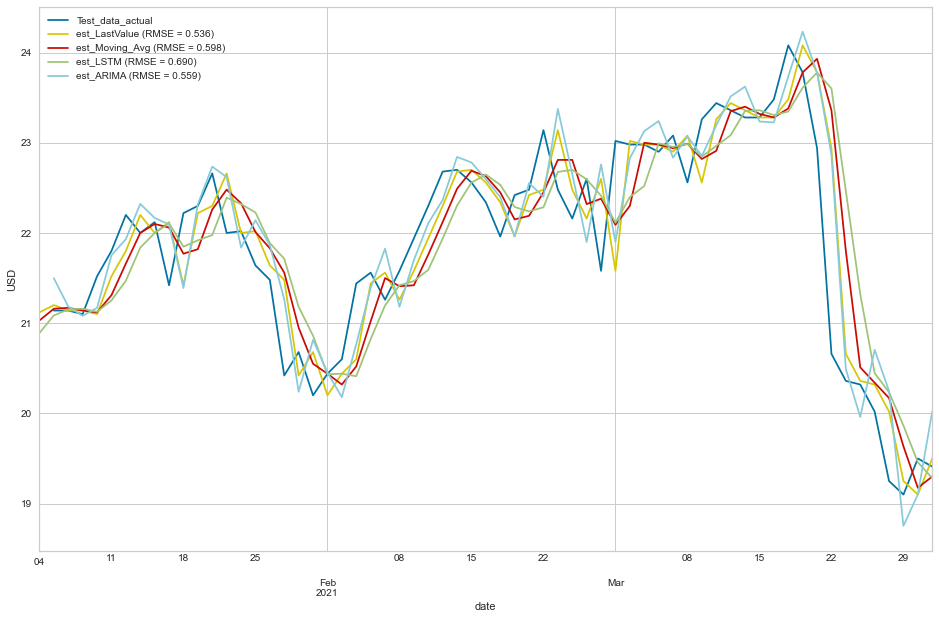

In [94]:
## Comparing Models
### Plotting predictions from 4 Models
rcParams['figure.figsize'] = 16, 10 

ax = test.plot(x='date', y='price', style='b-', grid=True)
ax = test_merged.plot(x='date', y='est_LV', style='y-', grid=True, ax=ax)
ax = test_merged.plot(x='date', y='est_MA', style='r-', grid=True, ax=ax)
ax = test_merged.plot(x='date', y='est_LSTM', style='g-', grid=True, ax=ax)
ax = test_merged.plot(x='date', y='est_ARIMA', style='c-', grid=True, ax=ax)
ax.legend(['Test_data_actual', 'est_LastValue (RMSE = 0.536)', 'est_Moving_Avg (RMSE = 0.598)', 'est_LSTM (RMSE = 0.690)', 'est_ARIMA (RMSE = 0.559)'])
ax.set_xlabel("date")
ax.set_ylabel("USD")